In [1]:
import numpy as np
import networkx as nx
from mat4py import loadmat
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
from PIL import Image

In [1]:
def selfDiffuse(W):
    D=[]
    for i in range (0, len(W)):
        w=0
        for j in range (0, len(W)):
            w+=W[i][j]
        D.append(w)
    D_1=np.linalg.inv(np.diag(D)) 
    P=np.dot(D_1,W)
    #function to find t optimal
    def t_opt(W,P):
        #the eigenvalues of P matrix in descending order
        vals,vecs= np.linalg.eig(P)
        sort= np.argsort(vals)[::-1]
        vals=vals[sort]
        #first ln 
        wp=np.dot(W,P)
        denom1=len(vals)-P.trace()
        denom2= np.linalg.norm(W-wp-np.identity(len(W)))
        denom=denom1*denom2
        ln1=math.log(0.001/denom) # 0.0001 is selected as small number
        #second ln 
        ln2=math.log(vals[1]-0.05) # C is set to 0.05 as authors indicate that 0.05 found as the best value for C
        t=np.ceil(ln1/ln2)
        #if one wants to check the t_opt, need to run the code below:
        #print(t)
        return int(t)
    #algorithm
    for i in range (0,t_opt(W,P)):
        W=np.dot(W,P)+np.identity(len(W))
    return np.dot(W,D_1)

In [2]:
data = loadmat('brainGraph1.mat') #load data here
A_B1 = np.array(list(data.values()))[0]
data = loadmat('brainGraph2.mat')
A_B2 = np.array(list(data.values()))[0]

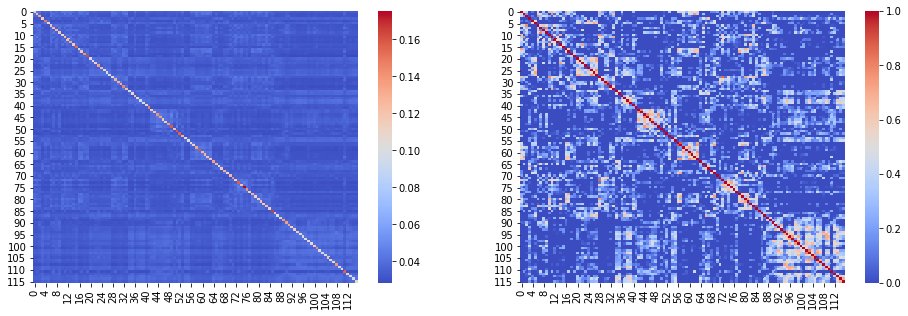

In [972]:
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.heatmap(pd.DataFrame(SF_B1),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(A_B1),cmap="coolwarm", ax=ax2 )

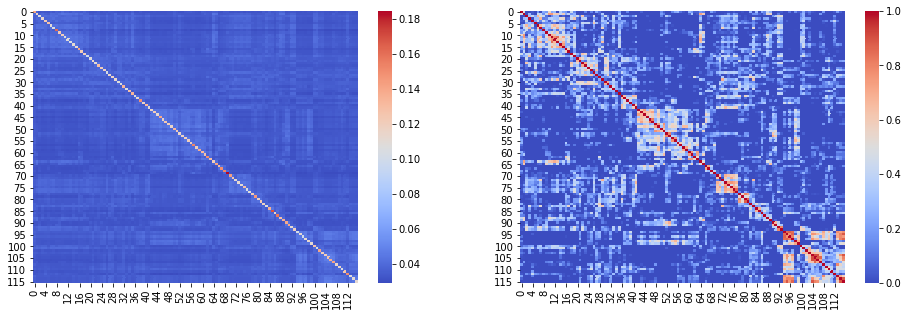

In [973]:
fig= plt.figure(figsize=(16,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
sns.heatmap(pd.DataFrame(SF_B2),cmap="coolwarm", ax=ax1)
sns.heatmap(pd.DataFrame(A_B2),cmap="coolwarm", ax=ax2 )

In [974]:
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *
def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

In [984]:
def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    #if sum(abs(S-S.T)) > 1e-10:
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k, iter=600)
    code,distance = vq(features,centroids)
        
    return code,V

In [1025]:
#please write the file path of the image file between '()'
im1=Image.open('image1.jpg') #load image here
#image is resized in order to deal with the memory limit
im1 = im1.resize((int(list(im1.size)[0]/8),int(list(im1.size)[1]/8)),Image.NEAREST)

In [1026]:
#affinity matrix obtained by N-cut algorithm
W_Ncut1=ncut_graph_matrix(np.asarray(im1).astype(np.float32))

In [1027]:
#clusters from affinity matrix in order to label each pixel
#Two cluster is prefered since the image can be represented by two colors
l1, V =cluster(W_Ncut1,2,1)
l2, V =cluster(W_Ncut1,3,2)
l3, V =cluster(W_Ncut1,4,3)

In [1028]:
m1,n1 = np.array(im1).shape[:2]
#labels are reshaped according to the shape of the image
labels_1=np.array(l1).reshape(m1,n1)
labels_2=np.array(l2).reshape(m1,n1)
labels_3=np.array(l3).reshape(m1,n1)

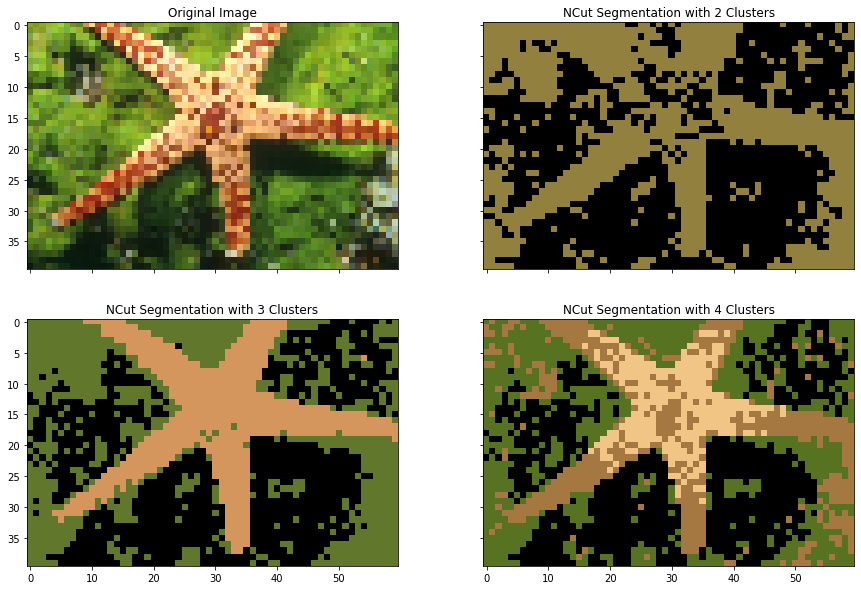

In [1029]:
segmentation_1 = color.label2rgb(labels_1, np.array(im1), kind='avg', bg_label=0)
segmentation_2 = color.label2rgb(labels_2, np.array(im1), kind='avg', bg_label=0)
segmentation_3 = color.label2rgb(labels_3, np.array(im1), kind='avg', bg_label=0)
fig, ax = plt.subplots(nrows= 2, ncols=2, sharex=True, sharey=True, figsize=(15, 10))
ax[0][0].set_title('Original Image')
ax[0][0].imshow(im1)
ax[0][1].set_title('NCut Segmentation with 2 Clusters')
ax[0][1].imshow(segmentation_1)
ax[1][0].set_title('NCut Segmentation with 3 Clusters')
ax[1][0].imshow(segmentation_2)
ax[1][1].set_title('NCut Segmentation with 4 Clusters')
ax[1][1].imshow(segmentation_3)
plt.show()

In [1030]:
im2=Image.open('image2.jpg')#load image here
im2 = im2.resize((int(list(im2.size)[0]/8),int(list(im2.size)[1]/8)),Image.NEAREST)

In [1031]:
W_Ncut2=ncut_graph_matrix(np.asarray(im2).astype(np.float32))

In [1076]:
#clusters from affinity matrix in order to label each pixel
#Two cluster is prefered since the image can be represented by two colors
l1, V =cluster(W_Ncut2,5,4)
l2, V =cluster(W_Ncut2,7,6)
l3, V =cluster(W_Ncut2,12,11)

In [1077]:
m1,n1 = np.array(im2).shape[:2]
#labels are reshaped according to the shape of the image
labels_1=np.array(l1).reshape(m1,n1)
labels_2=np.array(l2).reshape(m1,n1)
labels_3=np.array(l3).reshape(m1,n1)

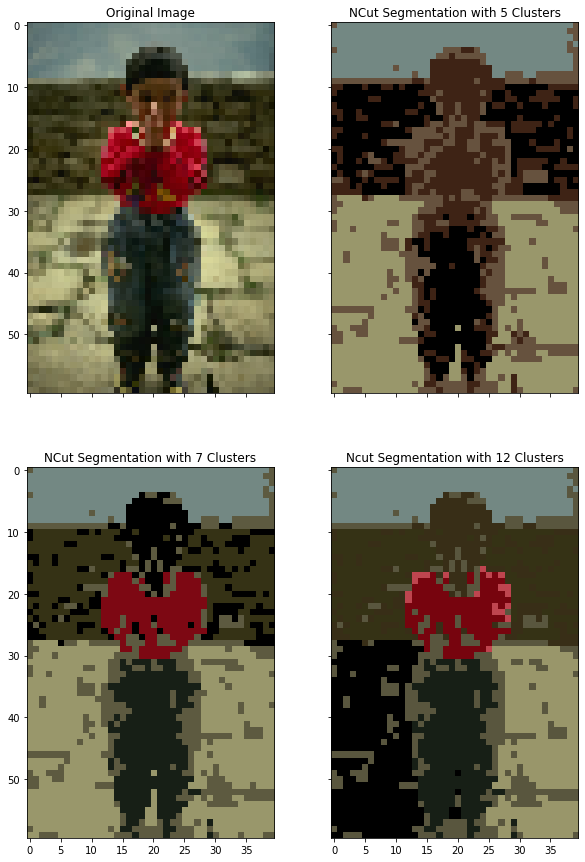

In [1079]:
segmentation_1 = color.label2rgb(labels_1, np.array(im2), kind='avg', bg_label=0)
segmentation_2 = color.label2rgb(labels_2, np.array(im2), kind='avg', bg_label=0)
segmentation_3 = color.label2rgb(labels_3, np.array(im2), kind='avg', bg_label=0)
fig, ax = plt.subplots(nrows= 2, ncols=2, sharex=True, sharey=True, figsize=(10, 15))
ax[0][0].set_title('Original Image')
ax[0][0].imshow(im2)
ax[0][1].set_title('NCut Segmentation with 5 Clusters')
ax[0][1].imshow(segmentation_1)
ax[1][0].set_title('NCut Segmentation with 7 Clusters')
ax[1][0].imshow(segmentation_2)
ax[1][1].set_title('Ncut Segmentation with 12 Clusters')
ax[1][1].imshow(segmentation_3)
plt.show()

In [1038]:
def t_opt(W):
    #given W similarity matrix, optimum number of iteration is printed
    D=[]
    for i in range (0, len(W)):
        w=0
        for j in range (0, len(W)):
            w+=W[i][j]
        D.append(w)
    D_1=np.linalg.inv(np.diag(D)) 
    P=np.dot(D_1,W)
    #the eigenvalues of P matrix in descending order
    vals,vecs= np.linalg.eig(P)
    sort= np.argsort(vals)[::-1]
    vals=vals[sort]
    #first ln 
    wp=np.dot(W,P)
    denom1=len(vals)-P.trace()
    denom2= np.linalg.norm(W-wp-np.identity(len(W)))
    denom=denom1*denom2
    ln1=math.log(0.0001/denom)
    #second ln 
    ln2=math.log(vals[1]-0.05) 
    t=np.ceil(ln1/ln2)
    return int(t)

In [1039]:
def selfDiffuse_t(W,t):
    #given similarity matrix W, self diffusion is made t times
    D=[]
    for i in range (0, len(W)):
        w=0
        for j in range (0, len(W)):
            w+=W[i][j]
        D.append(w)
    D_1=np.linalg.inv(np.diag(D)) 
    P=np.dot(D_1,W)
    for i in range (0,t):
        W=np.dot(W,P)+np.identity(len(W))
    return np.dot(W,D_1)  

In [1044]:
def ncut_graph_matrix_SF(im,t,sigma_d=1e2,sigma_g=1e-2): # t is added as input
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    W_SF=selfDiffuse_t(W,t) # W matrix is self diffused t time
    return  W_SF

In [1139]:
#5 different iterations are set
t1=1
t3=t_opt(W_Ncut1)
t5=2*t3
t2=int(t1+(t3-t1)/2)
t4=int(t3+(t5-t3)/2)
m1,n1 = np.array(im1).shape[:2]
t=[t1, t2, t3, t4, t5]

In [1140]:
t

[1, 200, 399, 598, 798]

Since in first image there is only one object, I prefer to have 2 cluster to segment image-1 into object and background. Self diffuse + ncut algorithm is generated for each t=[1, 200, 399, 598, 798]

In [1141]:
W_SF_t1=ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t1)
l1, V =cluster(W_SF_t1,2,1)
labels_1=np.array(l1).reshape(m1,n1)

In [1142]:
W_SF_t2=ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t2)
l2, V =cluster(W_SF_t2,2,1)
labels_2=np.array(l2).reshape(m1,n1)

In [1143]:
W_SF_t3=ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t3)
l3, V =cluster(W_SF_t3,2,1)
labels_3=np.array(l3).reshape(m1,n1)

In [1144]:
W_SF_t4=ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t4)
l4, V =cluster(W_SF_t4,2,1)
labels_4=np.array(l4).reshape(m1,n1)

In [1145]:
W_SF_t5=ncut_graph_matrix_SF(np.asarray(im1).astype(np.float32),t5)
l5, V =cluster(W_SF_t5,2,1)
labels_5=np.array(l5).reshape(m1,n1)

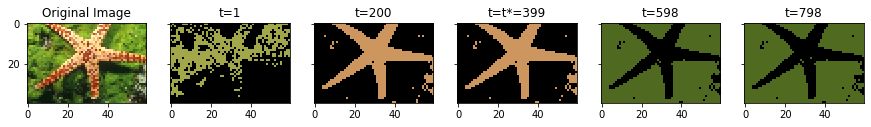

In [1146]:
segmentation_1 = color.label2rgb(labels_1, np.array(im1), kind='avg', bg_label=0)
segmentation_2 = color.label2rgb(labels_2, np.array(im1), kind='avg', bg_label=0)
segmentation_3 = color.label2rgb(labels_3, np.array(im1), kind='avg', bg_label=0)
segmentation_4 = color.label2rgb(labels_4, np.array(im1), kind='avg', bg_label=0)
segmentation_5 = color.label2rgb(labels_5, np.array(im1), kind='avg', bg_label=0)
fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(15, 10))
ax[0].set_title('Original Image')
ax[0].imshow(im1)
ax[1].set_title('t=1')
ax[1].imshow(segmentation_1)
ax[2].set_title('t=200')
ax[2].imshow(segmentation_2)
ax[3].set_title('t=t*=399')
ax[3].imshow(segmentation_3)
ax[4].set_title('t=598')
ax[4].imshow(segmentation_4)
ax[5].set_title('t=798')
ax[5].imshow(segmentation_5)
plt.show()

Above figure reveals how self diffusion can improve image segmentation, in which with the optimum iteration time star fish is exactly seperated from image, where silhouettes (dark parts on background) are also indicated. Smaller iteration or much iteration led to have thinner star fish. Results also show the succes in determining t*.  

In [1106]:
#5 different iterations are set
t1=1
t3=t_opt(W_Ncut2)
t5=2*t3
t2=int(t1+(t3-t1)/2)
t4=int(t3+(t5-t3)/2)
m1,n1 = np.array(im2).shape[:2]
t_2=[t1, t2, t3, t4, t5]

In [1132]:
t_2

[1, 207, 413, 619, 826]

In [1121]:
W_SF_t1=ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t1)
l1, V =cluster(W_SF_t1,7,6)
labels_1=np.array(l1).reshape(m1,n1)

In [1122]:
W_SF_t2=ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t2)
l2, V =cluster(W_SF_t2,7,6)
labels_2=np.array(l2).reshape(m1,n1)

In [1123]:
W_SF_t3=ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t3)
l3, V =cluster(W_SF_t3,7,6)
labels_3=np.array(l3).reshape(m1,n1)

In [1129]:
W_SF_t4=ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t4)
l4, V =cluster(W_SF_t4,7,6)
labels_4=np.array(l4).reshape(m1,n1)

In [1130]:
W_SF_t5=ncut_graph_matrix_SF(np.asarray(im2).astype(np.float32),t5)
l5, V =cluster(W_SF_t5,7,6)
labels_5=np.array(l5).reshape(m1,n1)

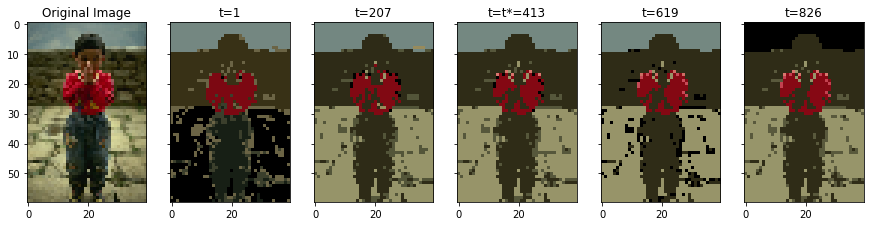

In [1135]:
segmentation_1 = color.label2rgb(labels_1, np.array(im2), kind='avg', bg_label=0)
segmentation_2 = color.label2rgb(labels_2, np.array(im2), kind='avg', bg_label=0)
segmentation_3 = color.label2rgb(labels_3, np.array(im2), kind='avg', bg_label=0)
segmentation_4 = color.label2rgb(labels_4, np.array(im2), kind='avg', bg_label=0)
segmentation_5 = color.label2rgb(labels_5, np.array(im2), kind='avg', bg_label=0)
fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(15, 10))
ax[0].set_title('Original Image')
ax[0].imshow(im2)
ax[1].set_title('t=1')
ax[1].imshow(segmentation_1)
ax[2].set_title('t=207')
ax[2].imshow(segmentation_2)
ax[3].set_title('t=t*=413')
ax[3].imshow(segmentation_3)
ax[4].set_title('t=619')
ax[4].imshow(segmentation_4)
ax[5].set_title('t=826')
ax[5].imshow(segmentation_5)
plt.show()

By implementing self diffusion to given image, border of the child, and the changes in background are separated. The succes of t optimum can be seen again, where before reaching t optimum and after t optimum segmatation gets worse.

 The superiorty of self diffusion + ncut algorithm over only ncut algorithm is revealed by both images.